Problem 2 and 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Data_folder_path = '/content/drive/MyDrive/Data'
CSV_path = '/content/drive/MyDrive/Data/robot_log.csv'
#CSV_path1 =  '/content/drive/Shareddrives/ME_592/HW3/Felipe/Data/Training/robot_log.csv'
#CSV_path2 =  '/content/drive/Shareddrives/ME_592/HW3/Benjamin/data/task 1/robot_log.csv'
#CSV_path3 =  '/content/drive/Shareddrives/ME_592/HW3/Julia/train/robot_log.csv'

Image_path = '/content/drive/MyDrive/Data/IMG'
#Image_path1 = '/content/drive/Shareddrives/ME_592/HW3/Felipe/Data/Training/IMG'
#Image_path2 = '/content/drive/Shareddrives/ME_592/HW3/Benjamin/data/task 1/IMG'
#Image_path3 = '/content/drive/Shareddrives/ME_592/HW3/Julia/train/IMG'

In [ ]:
import os
import pandas as pd
from os.path import join
import glob
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    #cv2_imshow(warped)
    return warped

In [ ]:
def load_input_training_data(img_path):
  os.chdir(img_path)
  #print(os.getcwd())
  images = []
  dst_size = 5 
  # Set a bottom offset to account for the fact that the bottom of the image 
  # is not the position of the rover but a bit in front of it
  # this is just a rough guess, feel free to change it!
  bottom_offset = 6
  source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

  for filename in sorted(os.listdir(img_path)):
  #for filename in sorted(file_names):
    #if(len(filename)>4):
    #print(filename)
    image = cv2.imread(filename)
    #cv2_imshow(image)
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    
    image = perspect_transform(image, source, destination)
    image = block_reduce(image, block_size=(5,10,1), func=np.max)
    #cv2_imshow(image)
    
    #image = color_thresh(image)
    
    #cv2_imshow(image)
    #print(type(image))
    #print(image.shape)
    images.append(image)
    #input()

  return np.array(images, dtype=np.float32)

In [ ]:
def load_output_training_data(csv_path, dir_path, load=False):
  #print(os.listdir(dir_path))
  #input()
  raw_data = pd.read_csv(csv_path, delimiter=';')
  raw_data['Path'] = raw_data['Path'].replace('/Users/hjy/IMG/','', regex=True)
  raw_data = raw_data[raw_data['Path'].isin(os.listdir(dir_path))]
  #print(raw_data)
  
  training_lables = raw_data[['SteerAngle','Throttle']]

  return training_lables.to_numpy(dtype=np.float32)

In [ ]:
train_x = load_input_training_data(Image_path)
print(train_x.shape)

(7382, 32, 32, 3)


In [ ]:
train_y = load_output_training_data(CSV_path, Image_path)
#print(sorted(os.listdir(Image_path)))
#print(inputImages[1])

print(train_y.shape)
#print(np.isnan(train_y))


(7382, 2)


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)

nRows,nCols,nDims = train_x.shape[1:]
train_x = train_x.reshape(train_x.shape[0], nDims, nRows, nCols)
print(train_x.shape)

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

print(train_x.shape)
print(train_y.shape)

nRows,nCols,nDims = val_x.shape[1:]
val_x = val_x.reshape(val_x.shape[0], nDims, nRows, nCols)
print(val_x.shape)

val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

#test_data = testing_input.reshape(testing_input.shape[0], nRows, nCols, nDims)
#input_shape = (nRows, nCols, nDims)

#train_data = train_data.astype('float32')
#test_data = test_data.astype('float32')
#train_data /=255

(6643, 3, 32, 32)
torch.Size([6643, 3, 32, 32])
torch.Size([6643, 2])
(739, 3, 32, 32)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2, 0)
        #self.conv2 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        #self.fc5 = nn.Linear(16, 1)
        self.fc5 = nn.Linear(16, 2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = F.relu(self.conv1(x))
        
        #x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.MSELoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [ ]:
model = Net()
criterion, optimizer = createLossAndOptimizer(model)
#optimizer = optim.Adam(model.parameters(), lr=0.07)
# defining the loss function
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
def train(epoch):
  model.train()
  tr_loss = 0
  x_train, y_train = Variable(train_x), Variable(train_y)
  x_val, y_val = Variable(val_x), Variable(val_y)
  if torch.cuda.is_available():
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_val = x_val.cuda()
    y_val = y_val.cuda()
  optimizer.zero_grad()
  output_train = model(x_train)
  output_val = model(x_val)
  loss_train = criterion(output_train, y_train)
  loss_val = criterion(output_val, y_val)
  train_losses.append(loss_train.detach().cpu())
  val_losses.append(loss_val.detach().cpu())

  loss_train.backward()
  optimizer.step()
  tr_loss = loss_train.item()
  if epoch%2 == 0:
      # printing the validation loss
      print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
  torch.save(model, str(epoch))

  # defining the number of epochs
n_epochs = 500
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
PATH = '/content/drive/MyDrive/Data/Models'
os.chdir(PATH)
for epoch in range(n_epochs):
    train(epoch)
    



Epoch :  1 	 loss : tensor(50.0604, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  3 	 loss : tensor(159.6376, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  5 	 loss : tensor(82.8771, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  7 	 loss : tensor(44.8706, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  9 	 loss : tensor(43.5228, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  11 	 loss : tensor(44.2234, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  13 	 loss : tensor(43.1740, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  15 	 loss : tensor(40.4859, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  17 	 loss : tensor(37.8243, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  19 	 loss : tensor(36.1873, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  21 	 loss : tensor(35.4014, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  23 	 loss : tensor(35.0638, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  25 	 loss :

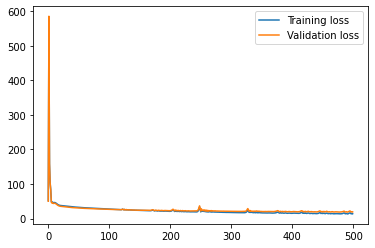

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
output = model(Variable(train_x).cuda())
#print(len(output))
#print(sum(output))
#print(output.max())
#print(output.min())
#print(sum((output*Variable(train_y).cuda()).sign()))
#print((output*Variable(train_y).cuda()).sign())


# accuracy on training set

In [ ]:
model = torch.load('/content/drive/MyDrive/Data/Models/150')
#model.eval()
test_x = load_input_training_data('/content/drive/MyDrive/Test/IMG')

nRows,nCols,nDims = test_x.shape[1:]
test_x = test_x.reshape(test_x.shape[0], nDims, nRows, nCols)

test_x = torch.from_numpy(test_x)
x_test = Variable(test_x)
x_test = x_test.cuda()
output = model(x_test)
output_np = output.cpu().detach().numpy()
#print(output.cpu().detach().numpy())
print('Steering angle, Throttle', output_np[1])



os.chdir('/content/drive/MyDrive/Data/Test/IMG')
i = 0
for filename in sorted(os.listdir('/content/drive/MyDrive/Data/Test/IMG')):
  
  #for filename in sorted(file_names):
  #if(len(filename)>4):
  #print(filename)
  image = cv2.imread(filename)
  cv2.putText(img=image, text='Steering angle, Throttle:'+str(output_np[i]), org=(10, 120), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.35, color=(0, 0, 0),thickness=1)
  cv2_imshow(image)
  cv2.imwrite(os.path.join('/content/drive/MyDrive/Data/Results/' + str(i)+'.jpg'), image)
  #input()
  i += 1
  print(i)




In [ ]:
torch.cuda.empty_cache()